In [1]:
import torch
import time
import random
import sys
import matplotlib.pyplot as plt
import torch.nn as nn
from transformers import AdamW
from torch.utils.data import Dataset
import pandas as pd
import torch
from transformers import BertConfig, BertForSequenceClassification
from transformers import BertTokenizer
from torch.utils.data import DataLoader
device='cuda' if torch.cuda.is_available() else 'cpu'

d:\Anaconda\envs\tf_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!nvidia-smi

Sun May  8 16:46:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.47       Driver Version: 497.47       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0    31W /  N/A |    149MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import re
import os 
def rm_tags(text):
    re_tags = re.compile(r'<[^>]+>')
    return re_tags.sub(' ',text)

def read_files(filetype):
    path = "C:/Users/20123/Desktop/计算机/深度学习/lab3/.data/imdb/aclImdb/"
    file_list=[]
    
    positive_path = path + filetype + "/pos/"
    for f in os.listdir(positive_path):
        file_list += [positive_path + f]
        
    negative_path = path + filetype + "/neg/"
    for f in os.listdir(negative_path):
        file_list += [negative_path + f]   
        
    print("read",filetype,"files:",len(file_list))
    
    all_labels = ([1]*12500+[0]*12500)
    
    all_texts = []
    for fi in file_list:
        with open(fi,encoding = 'utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return all_labels,all_texts

y_train,train_text = read_files("train")
y_test,test_text = read_files("test")


read train files: 25000
read test files: 25000


In [4]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

sentences=train_text
labels=y_train

test_sentences=test_text
test_labels=y_test


Loading BERT tokenizer...


In [9]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))


 Original:  Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
Tokenized:  ['bro', '##m', '##well', 'high', 'is', 'a', 'cartoon', 'comedy', '.', 'it', 'ran', 'at', 'the', 'same', 'time', 'as', 'some', 'other', 'programs', 'about', 'school', 'li

In [5]:
MAX_LEN=128

input_ids = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in sentences]
test_input_ids=[tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in test_sentences]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [6]:
from keras.preprocessing.sequence import pad_sequences
print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")


Padding token: "[PAD]", ID: 0


In [7]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

test_attention_masks = []

# For each sentence...
for sent in test_input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    test_attention_masks.append(att_mask)


In [8]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2020, test_size=0.1)


In [9]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs=torch.tensor(test_input_ids)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels=torch.tensor(test_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks=torch.tensor(test_attention_masks)

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [10]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [11]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


d:\Anaconda\envs\tf_torch\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [12]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [13]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
loss_tr_hist = []
accuracy_tr_hist = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)

            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]
        total_loss += loss.item()
        loss_tr_hist.append(total_loss)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():        
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        accuracy_tr_hist.append(eval_accuracy/1563)

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,407.    Elapsed: 0:00:09.
  Batch    80  of  1,407.    Elapsed: 0:00:15.
  Batch   120  of  1,407.    Elapsed: 0:00:21.
  Batch   160  of  1,407.    Elapsed: 0:00:27.
  Batch   200  of  1,407.    Elapsed: 0:00:33.
  Batch   240  of  1,407.    Elapsed: 0:00:39.
  Batch   280  of  1,407.    Elapsed: 0:00:45.
  Batch   320  of  1,407.    Elapsed: 0:00:50.
  Batch   360  of  1,407.    Elapsed: 0:00:56.
  Batch   400  of  1,407.    Elapsed: 0:01:02.
  Batch   440  of  1,407.    Elapsed: 0:01:09.
  Batch   480  of  1,407.    Elapsed: 0:01:15.
  Batch   520  of  1,407.    Elapsed: 0:01:21.
  Batch   560  of  1,407.    Elapsed: 0:01:27.
  Batch   600  of  1,407.    Elapsed: 0:01:33.
  Batch   640  of  1,407.    Elapsed: 0:01:39.
  Batch   680  of  1,407.    Elapsed: 0:01:45.
  Batch   720  of  1,407.    Elapsed: 0:01:51.
  Batch   760  of  1,407.    Elapsed: 0:01:56.
  Batch   800  of  1,407.    Elapsed: 0:02:02.
  Batch   840  of

In [14]:
t0 = time.time()
model.eval()

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in test_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():        
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output
    # values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Calculate the accuracy for this batch of test sentences.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy
    # accuracy_tr_hist.append(eval_accuracy)

    # Track the number of batches
    nb_eval_steps += 1
print("  Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
print("  Test took: {:}".format(format_time(time.time() - t0)))

  Accuracy: 0.8882
  Test took: 0:01:07


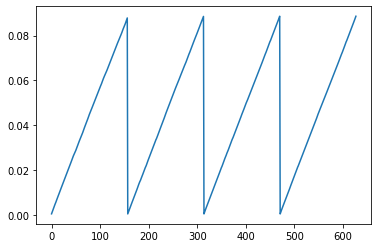

In [19]:
plt.plot(accuracy_tr_hist)
plt.savefig('acc.pdf')
plt.show()

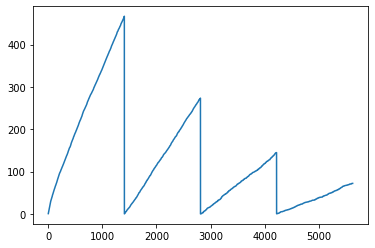

In [20]:
# l = [i/1407 for i in loss_tr_hist]
plt.plot(loss_tr_hist)
plt.savefig('loss.pdf')
plt.show()

In [17]:
len(accuracy_tr_hist),len(loss_tr_hist)

(628, 5628)

In [47]:
nb_eval_steps

1563